<h3>Contrast adjustment</h3>

Text(0.5, 1.0, 'Alpha=3')

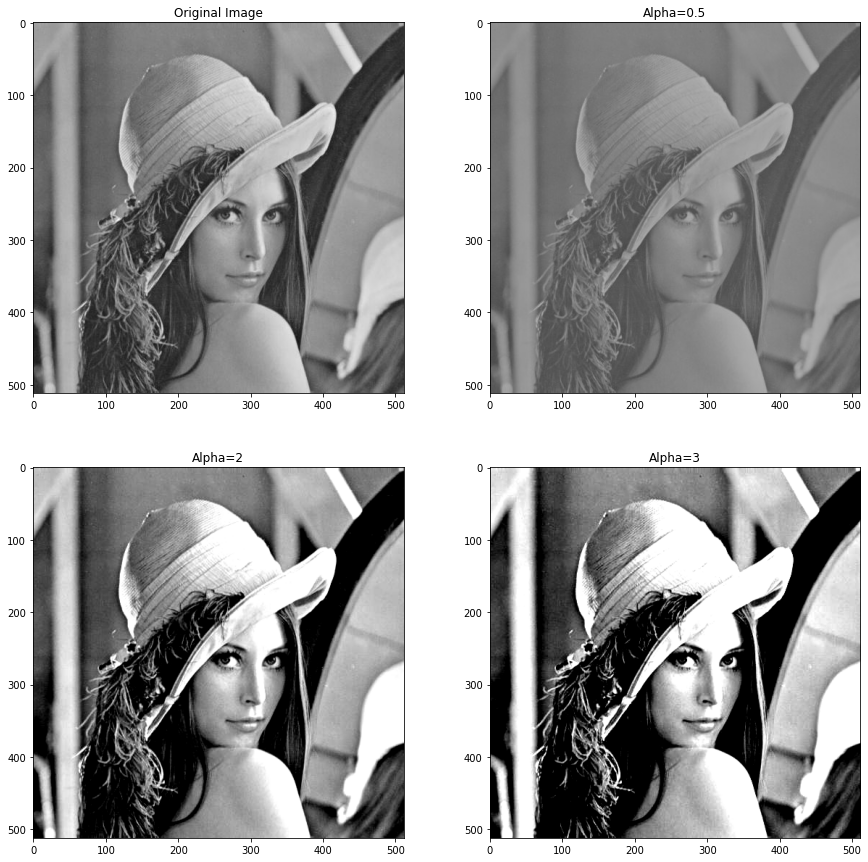

In [1]:
from PIL import Image, ImageStat
import matplotlib.pyplot as plt

class _Enhance:
    def enhance(self, factor):
        return Image.blend(self.degenerate, self.image, factor)
    

class Contrast(_Enhance):
    def __init__(self, image):
        self.image = image
        mean = int(ImageStat.Stat(image.convert("L")).mean[0] + 0.5)
        self.degenerate = Image.new("P", image.size, mean).convert(image.mode)

        if "A" in image.getbands():
            self.degenerate.putalpha(image.getchannel("A"))
            
            
im = Image.open("lena_gray.jpg")

#image brightness enhancer
enhancer = Contrast(im)

fig, ax = plt.subplots(2,2, figsize=(15,15))
ax[0][0].imshow(im)
ax[0][0].set_title('Original Image')
im_output = enhancer.enhance(0.5)
ax[0][1].imshow(im_output);
ax[0][1].set_title('Alpha=0.5')
im_output = enhancer.enhance(2)
ax[1][0].imshow(im_output)
ax[1][0].set_title('Alpha=2')
im_output = enhancer.enhance(3)
ax[1][1].imshow(im_output)
ax[1][1].set_title('Alpha=3')

Text(0.5, 1.0, 'Alpha=3')

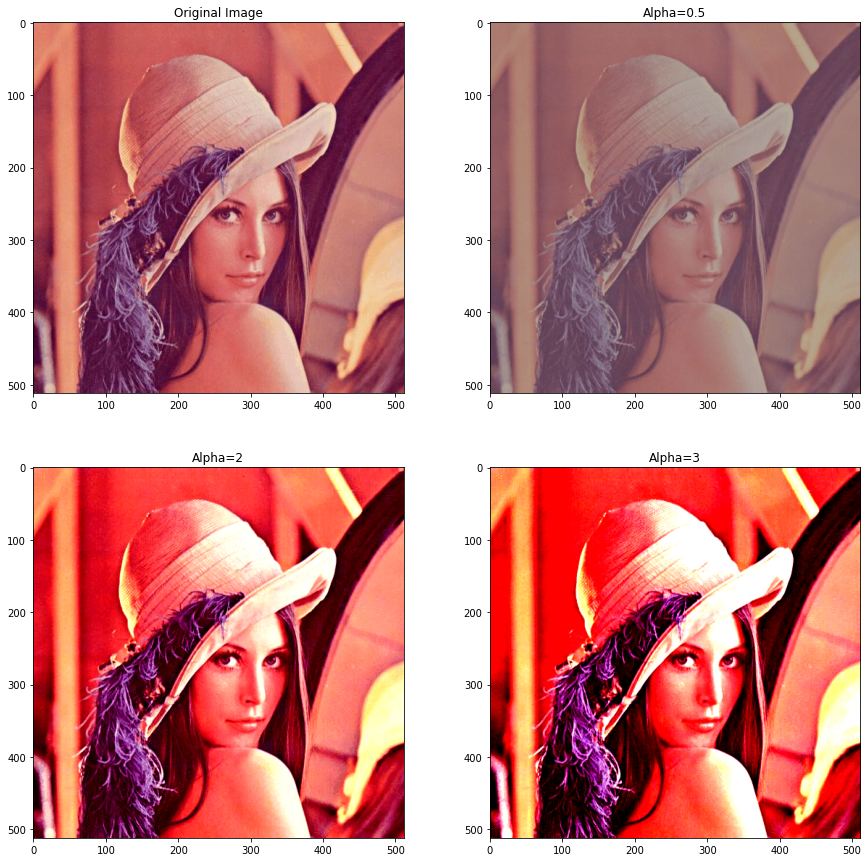

In [2]:
im = Image.open("lena_color.jpg")

#image brightness enhancer
enhancer = Contrast(im)

fig, ax = plt.subplots(2,2, figsize=(15,15))
ax[0][0].imshow(im)
ax[0][0].set_title('Original Image')

im_output = enhancer.enhance(0.5)
ax[0][1].imshow(im_output);
ax[0][1].set_title('Alpha=0.5')
im_output = enhancer.enhance(2)
ax[1][0].imshow(im_output)
ax[1][0].set_title('Alpha=2')
im_output = enhancer.enhance(3)
ax[1][1].imshow(im_output)
ax[1][1].set_title('Alpha=3')

Text(0.5, 1.0, 'Alpha=3')

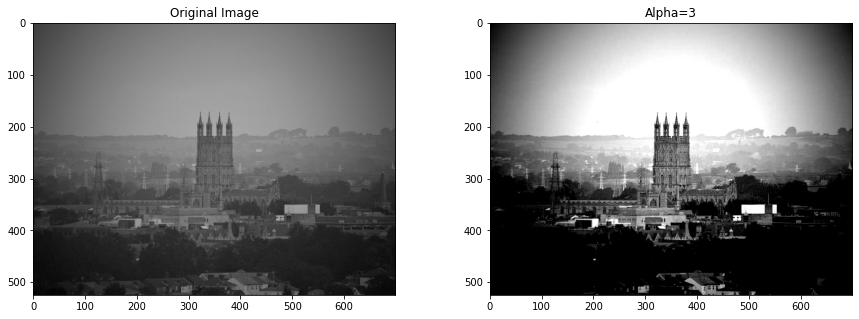

In [3]:
im = Image.open("architecture.jpg")

#image brightness enhancer
enhancer = Contrast(im)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(im)
ax[0].set_title('Original Image')
factor = 3 #increase  constrast
im_output = enhancer.enhance(factor)
ax[1].imshow(im_output)
ax[1].set_title('Alpha=3')

<h3>Power-Law Transformation </h3>

Text(0.5, 1.0, 'Histogram')

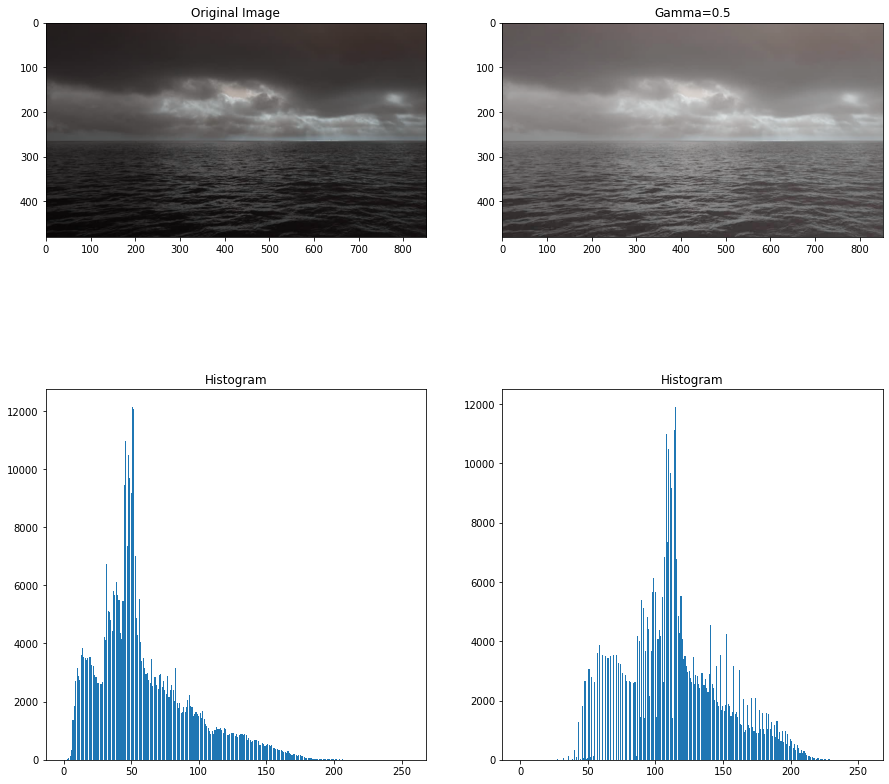

In [4]:
import cv2
import numpy as np

# Open the image.
img = cv2.imread('sea.jpg')
  
# Trying 1 gamma values.
gamma=0.5
# Apply gamma correction.
gamma_corrected = np.array(255*(img / 255) ** gamma, dtype = 'uint8')

fig, ax = plt.subplots(2,2, figsize=(15,15))

ax[0][0].imshow(img)
ax[0][0].set_title('Original Image')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
piexl=np.zeros(shape=(256,),dtype=int)
for i in gray.reshape(-1,):
    piexl[i]+=1
ax[1][0].bar(range(256),piexl)
ax[1][0].set_title('Histogram')


ax[0][1].imshow(gamma_corrected)
ax[0][1].set_title('Gamma=0.5')
gray = cv2.cvtColor(gamma_corrected, cv2.COLOR_BGR2GRAY)
piexl=np.zeros(shape=(256,),dtype=int)
for i in gray.reshape(-1,):
    piexl[i]+=1
ax[1][1].bar(range(256),piexl)
ax[1][1].set_title('Histogram')

<h3>Noise reduction</h3>

Text(0.5, 1.0, 'Filter size=9')

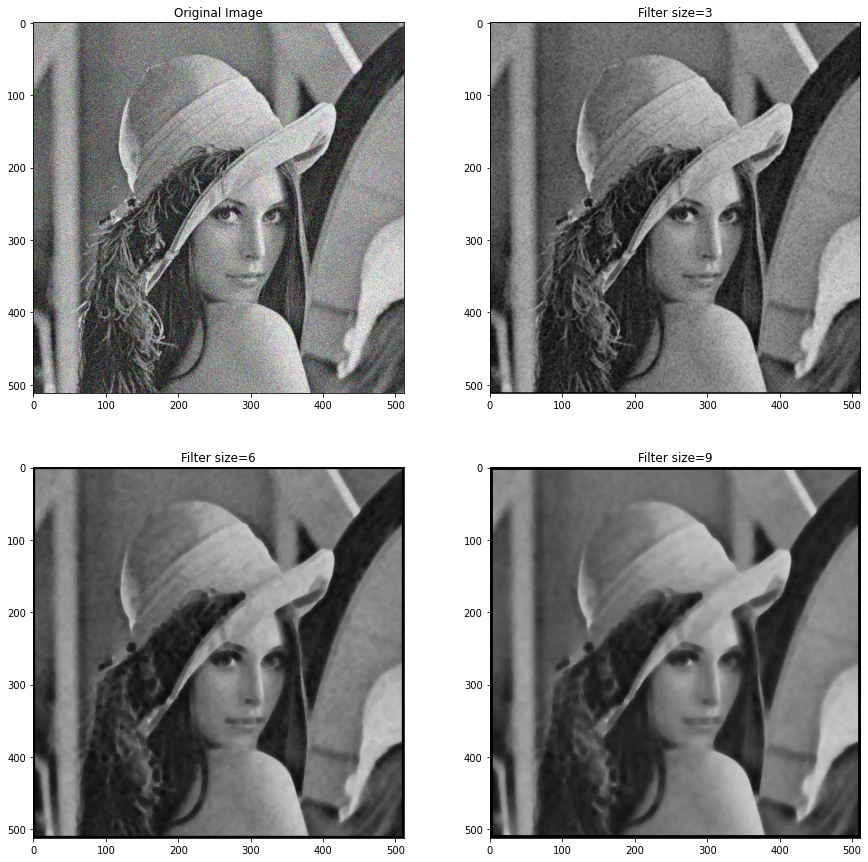

In [5]:
from numpy import divide, int8, multiply, ravel, sort, zeros_like

def median_filter(gray_img, mask=3):
    # set image borders
    bd = int(mask / 2)
    # copy image size
    median_img = zeros_like(gray_img)
    for i in range(bd, gray_img.shape[0] - bd):
        for j in range(bd, gray_img.shape[1] - bd):
            # get mask according with mask
            kernel = ravel(gray_img[i - bd : i + bd + 1, j - bd : j + bd + 1])
            # calculate mask median
            median = sort(kernel)[int8(divide((multiply(mask, mask)), 2) + 1)]
            median_img[i, j] = median
    return median_img

img = cv2.imread('noise_image.jpg')

fig, ax = plt.subplots(2,2, figsize=(15,15))
ax[0][0].imshow(img)
ax[0][0].set_title('Original Image')
new_img=median_filter(img,3)
ax[0][1].imshow(new_img);
ax[0][1].set_title('Filter size=3')
new_img=median_filter(img,6)
ax[1][0].imshow(new_img)
ax[1][0].set_title('Filter size=6')
new_img=median_filter(img,9)
ax[1][1].imshow(new_img)
ax[1][1].set_title('Filter size=9')

<h3>Color correction</h3>

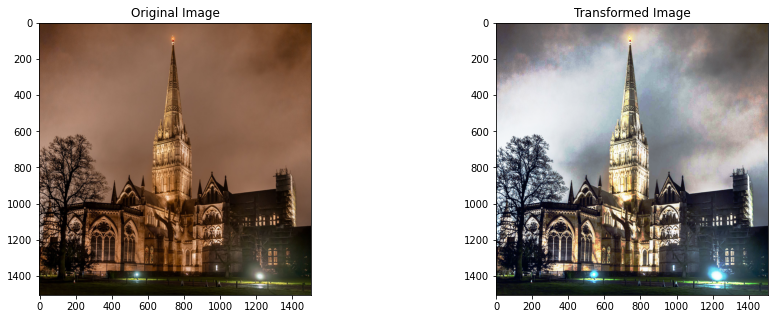

In [6]:
from skimage.io import imread, imshow
from skimage import img_as_ubyte
from skimage.color import rgb2gray
from scipy.stats import cauchy, logistic

def _get_numpy_hist_range(image, source_range):
    if source_range == 'image':
        hist_range = None
    elif source_range == 'dtype':
        hist_range = dtype_limits(image, clip_negative=False)
    else:
        ValueError('Wrong value for the `source_range` argument')
    return hist_range


def histogram(image, nbins=256, source_range='image', normalize=False, *,channel_axis=None):
    sh = image.shape
    if channel_axis is not None:
        channels = sh[-1]
        hist = []
        # compute bins based on the raveled array
        if np.issubdtype(image.dtype, np.integer):
            # here bins corresponds to the bin centers
            bins = _bincount_histogram_centers(image, source_range)
        else:
            # determine the bin edges for np.histogram
            hist_range = _get_numpy_hist_range(image, source_range)
            bins = _get_bin_edges(image, nbins, hist_range)
        for chan in range(channels):
            h, bc = _histogram(image[..., chan], bins, source_range, normalize)
            hist.append(h)
        # Convert to numpy arrays
        bin_centers = np.asarray(bc)
        hist = np.stack(hist, axis=0)
    else:
        hist, bin_centers = _histogram(image, nbins, source_range, normalize)
    return hist, bin_centers


def _histogram(image, bins, source_range, normalize):
    image = image.flatten()
    # For integer types, histogramming with bincount is more efficient.
    if np.issubdtype(image.dtype, np.integer):
        bin_centers = bins if isinstance(bins, np.ndarray) else None
        hist, bin_centers = _bincount_histogram(image, source_range, bin_centers)
    else:
        hist_range = _get_numpy_hist_range(image, source_range)
        hist, bin_edges = np.histogram(image, bins=bins, range=hist_range)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.

    if normalize:
        hist = hist / np.sum(hist)
    return hist, bin_centers


def cumulative_distribution(image, nbins=256):
    hist, bin_centers = histogram(image, nbins)
    img_cdf = hist.cumsum()
    img_cdf = img_cdf / float(img_cdf[-1])
    return img_cdf, bin_centers


def _bincount_histogram(image, source_range, bin_centers=None):
    if bin_centers is None:
        bin_centers = _bincount_histogram_centers(image, source_range)
    image_min, image_max = bin_centers[0], bin_centers[-1]
    image, offset = _offset_array(image, image_min, image_max)
    hist = np.bincount(image.ravel(), minlength=image_max - image_min + 1)
    if source_range == 'image':
        idx = max(image_min, 0)
        hist = hist[idx:]
    return hist, bin_centers


def _bincount_histogram_centers(image, source_range):
    """Compute bin centers for bincount-based histogram."""
    if source_range not in ['image', 'dtype']:
        raise ValueError(f'Incorrect value for `source_range` argument: {source_range}')
    if source_range == 'image':
        image_min = int(image.min().astype(np.int64))
        image_max = int(image.max().astype(np.int64))
    elif source_range == 'dtype':
        image_min, image_max = dtype_limits(image, clip_negative=False)
    bin_centers = np.arange(image_min, image_max + 1)
    return bin_centers


def _offset_array(arr, low_boundary, high_boundary):
    """Offset the array to get the lowest value at 0 if negative."""
    if low_boundary < 0:
        offset = low_boundary
        dyn_range = high_boundary - low_boundary
        # get smallest dtype that can hold both minimum and offset maximum
        offset_dtype = np.promote_types(np.min_scalar_type(dyn_range),np.min_scalar_type(low_boundary))
        if arr.dtype != offset_dtype:
            # prevent overflow errors when offsetting
            arr = arr.astype(offset_dtype)
        arr = arr - offset
    else:
        offset = 0
    return arr, offset


def linear_distribution(image, channel):
    image_intensity = image[:,:,channel]
    freq, bins = cumulative_distribution(image_intensity)
    target_bins = np.arange(255)
    target_freq = np.linspace(0, 1, len(target_bins))
    new_vals = np.interp(freq, target_freq, target_bins)
    return new_vals[image_intensity].astype(np.uint8)


cathedral = imread('Salisbury-cathedral.jpg')
red_channel = linear_distribution(cathedral, 0)
green_channel = linear_distribution(cathedral, 1)
blue_channel = linear_distribution(cathedral, 2)
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(cathedral)
ax[0].set_title('Original Image')
ax[1].imshow(np.dstack([red_channel, green_channel, blue_channel]));
ax[1].set_title('Transformed Image');